# Generate Phasor plots from FD-FLIM data
*Matt Renshaw* 
*CALM STP*
*The Francis Crick Institute*
*2025-09-19*  

**Background**: Phasor plots of FLIM data are a useful tool to analyse FLIM data in a fitting-independent way. 

**Aim**: Generate phasor plots from FD-FLIM data that has been processed and uploaded to OMERO.

In [1]:
import omero_utils as omero
import phasor_utils as phasor

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
username = 'rensham'

In [4]:
# connect to OMERO
conn = omero.connect(username)

Connected to OMERO server: omero-prod.camp.thecrick.org


## Hexbin Phasor plot from an OMERO image ID

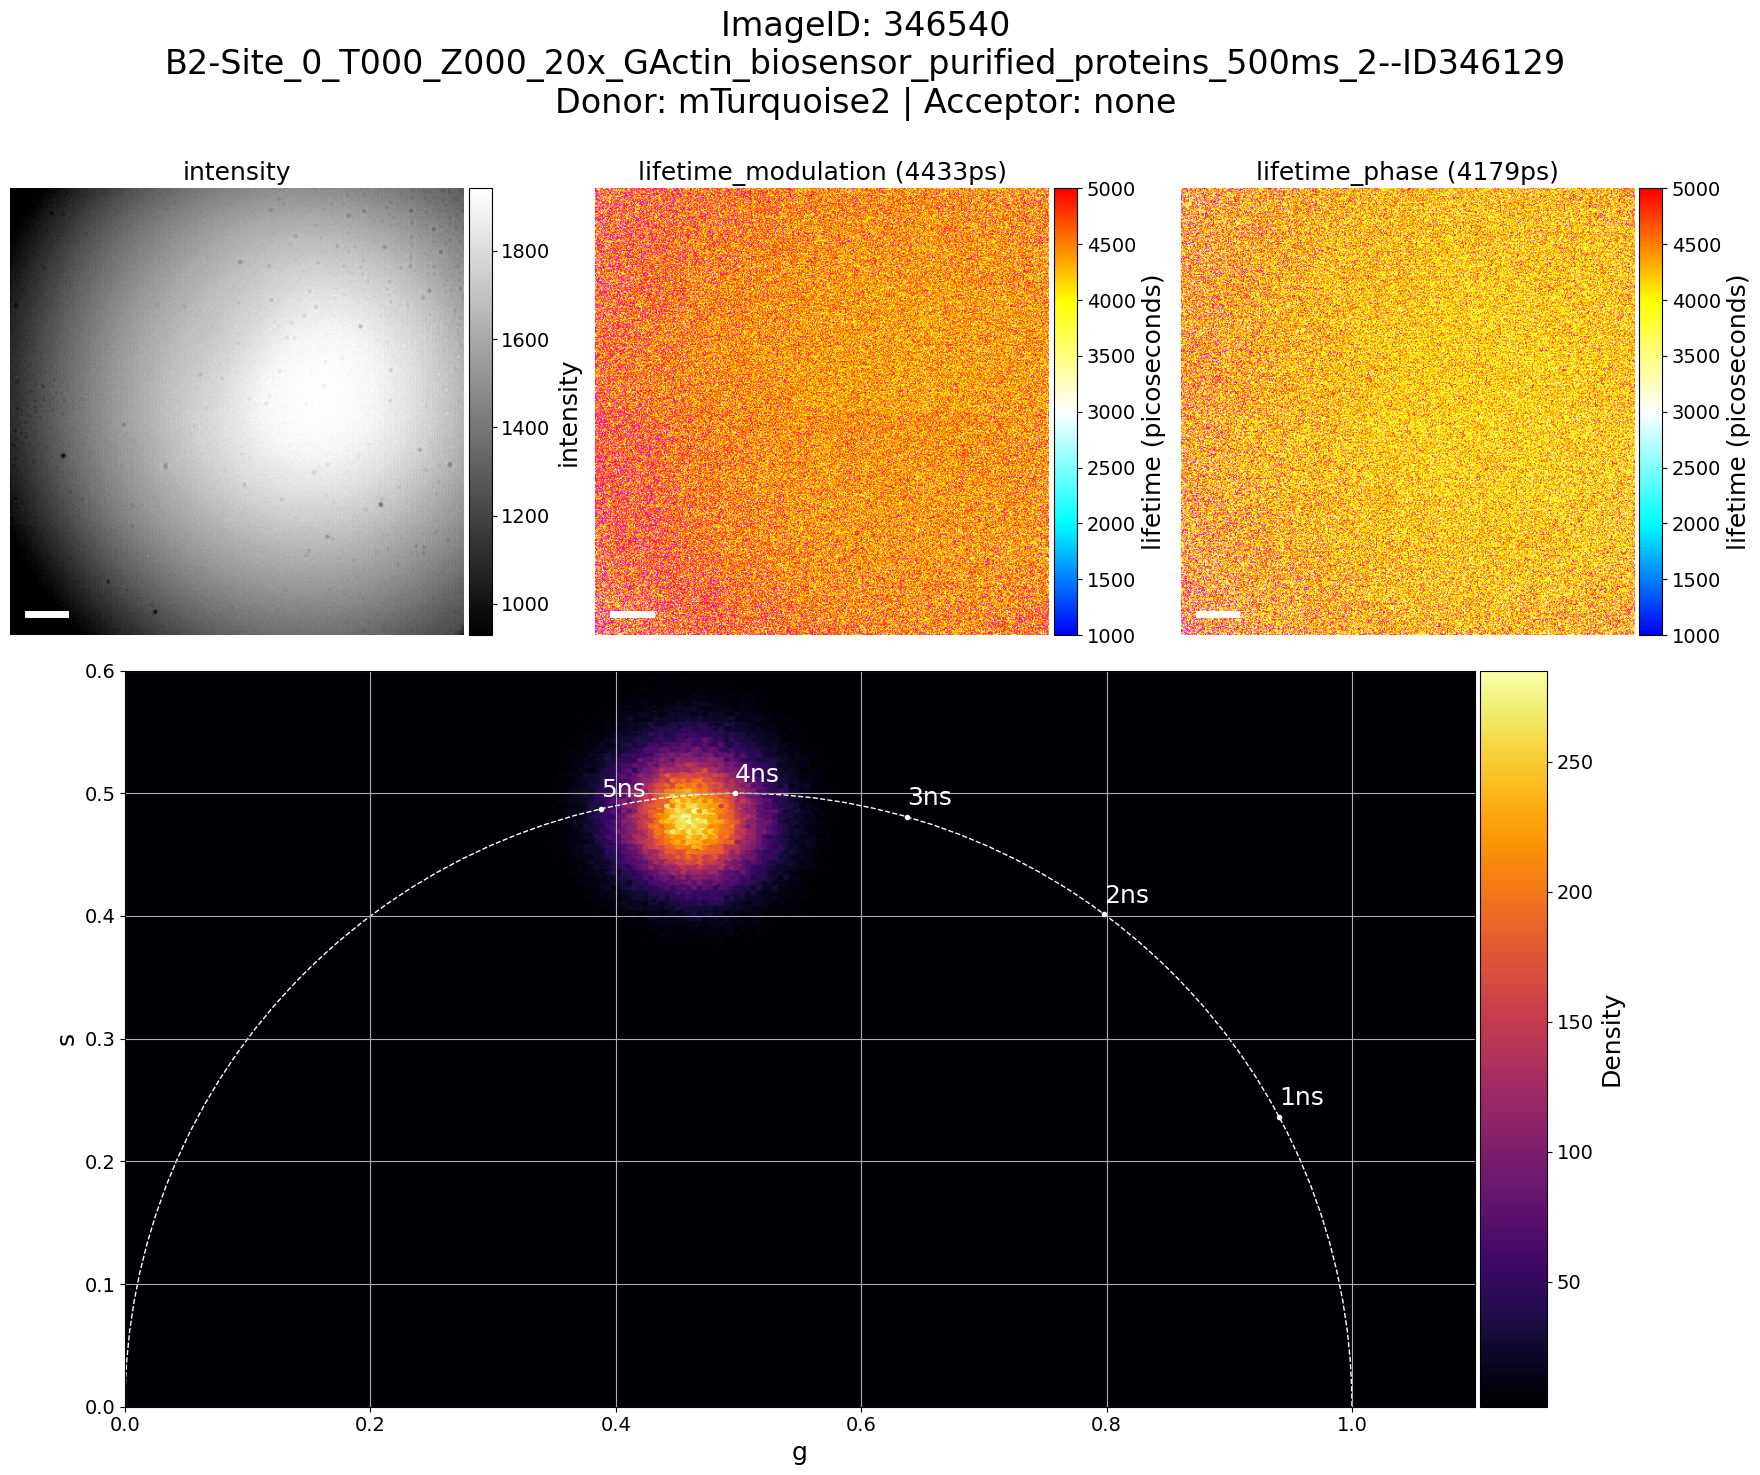

In [5]:
image_id = 346540
fig, gs = phasor.hexbin_phasor_plot (conn, image_id, vmin=1000, vmax = 5000)

## Use scatterplot to plot multiple datasets on a phasor plot

In [6]:
project_id = 4853
list_of_ids = omero.find_image_ids_in_project_kv_dict (conn, project_id, {"image_processing": "background subtraction"})

In [7]:
output = []
for image_id in list_of_ids:
    headings, output = phasor.get_values_image_id (conn, image_id, keys = ["Construct", "Sample ID", "LatB-G-Actin Concentration uM"], output = output)

In [8]:
# convert output values to pandas dataframe
df = pd.DataFrame(output, columns = headings)
df

,image_id,Donor,Acceptor,Construct,Sample ID,LatB-G-Actin Concentration uM,intensity,modulation_lifetime_ps,phase_lifetime_ps,g_value,s_value
0,350428,TurquoiseGL,none,TqGL,C2,100,1894.583374,4621.750488,3942.380859,0.463460,0.459209
1,350428,TurquoiseGL,none,TqGL,C2,100,1935.625000,5940.958984,4364.925781,0.374873,0.411245
2,350428,TurquoiseGL,none,TqGL,C2,100,1949.458374,4645.996582,4794.168945,0.415418,0.500539
3,350428,TurquoiseGL,none,TqGL,C2,100,2020.625000,3611.930420,5299.603516,0.444553,0.592115
4,350428,TurquoiseGL,none,TqGL,C2,100,2074.750000,3996.304932,5587.325684,0.409275,0.574724
...,...,...,...,...,...,...,...,...,...,...,...
14450683,350439,TurquoiseGL,yPet,123d,C4,100,361.416656,2859.780273,1768.514160,0.742023,0.329812
14450684,350439,TurquoiseGL,yPet,123d,C4,100,358.291656,2907.396484,1192.252686,0.773438,0.231757
14450685,350439,TurquoiseGL,yPet,123d,C4,100,351.416656,3158.209229,2547.172363,0.659660,0.422297
14450686,350439,TurquoiseGL,yPet,123d,C4,100,327.125000,3925.851807,2863.296875,0.577780,0.415785


In [9]:
# get omega value
img = conn.getObject("Image", list_of_ids[0])
# read metadata annotations (k-v pairs)
metadata_dict = {}
for ann in img.listAnnotations():
    map_ann = conn.getObject("MapAnnotation", ann.getId())
    for k, v in map_ann.getValue():
        metadata_dict[k] = v

omega = float(metadata_dict["omega"])

In [10]:
# Group by category and compute mean
grouped_average = df.groupby(["image_id", "Construct", "Sample ID", "LatB-G-Actin Concentration uM"])[["intensity", "modulation_lifetime_ps", "phase_lifetime_ps", "g_value", "s_value"]].mean().reset_index()

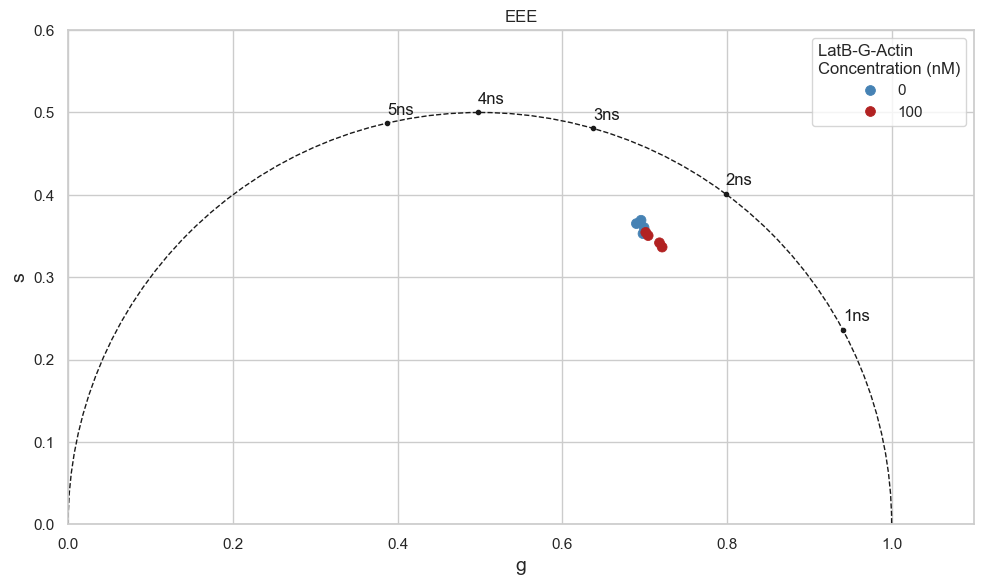

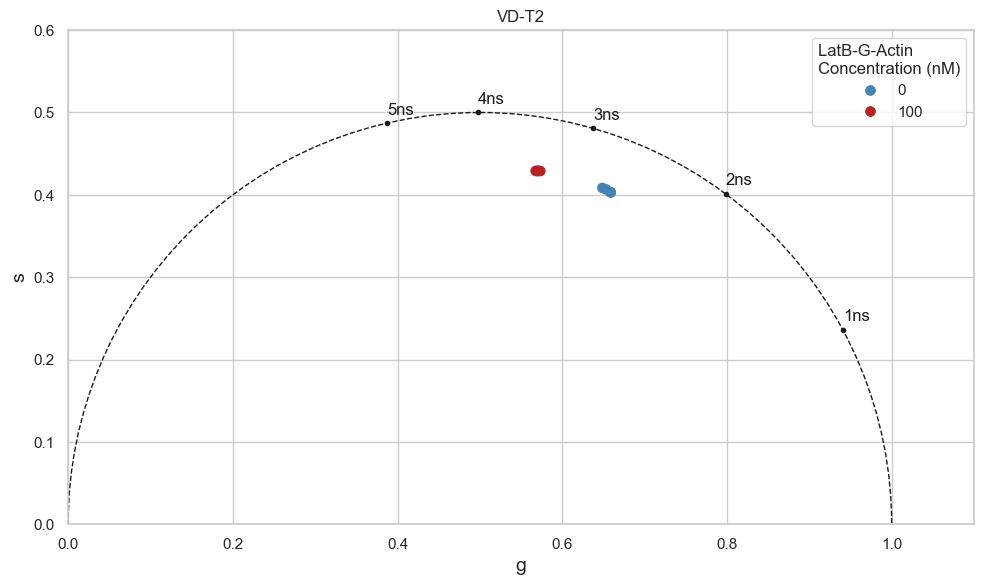

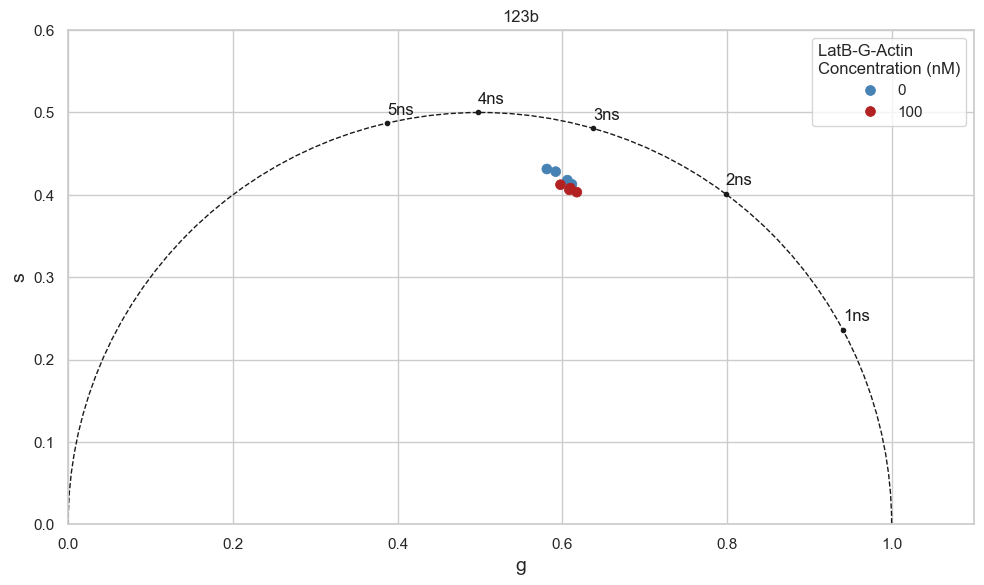

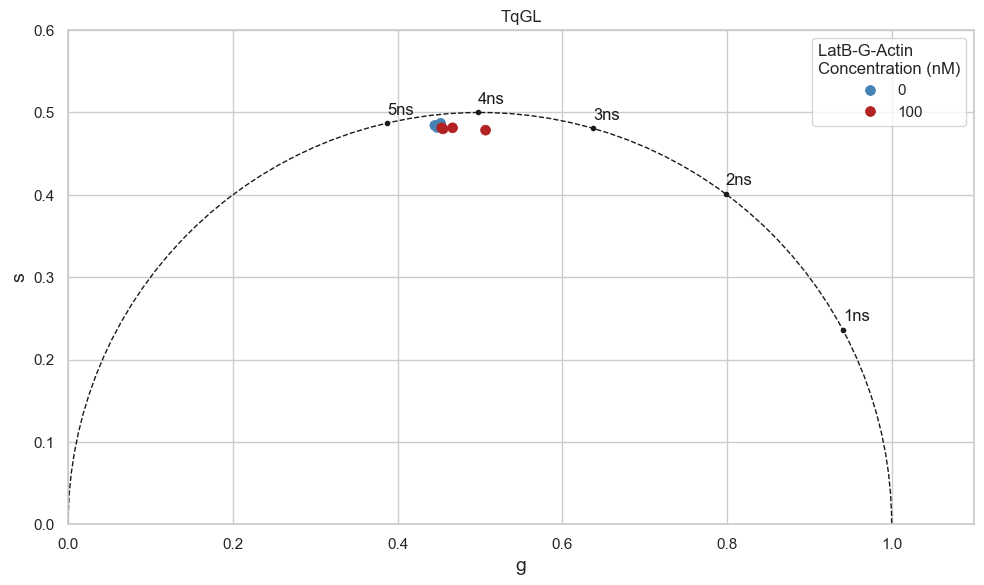

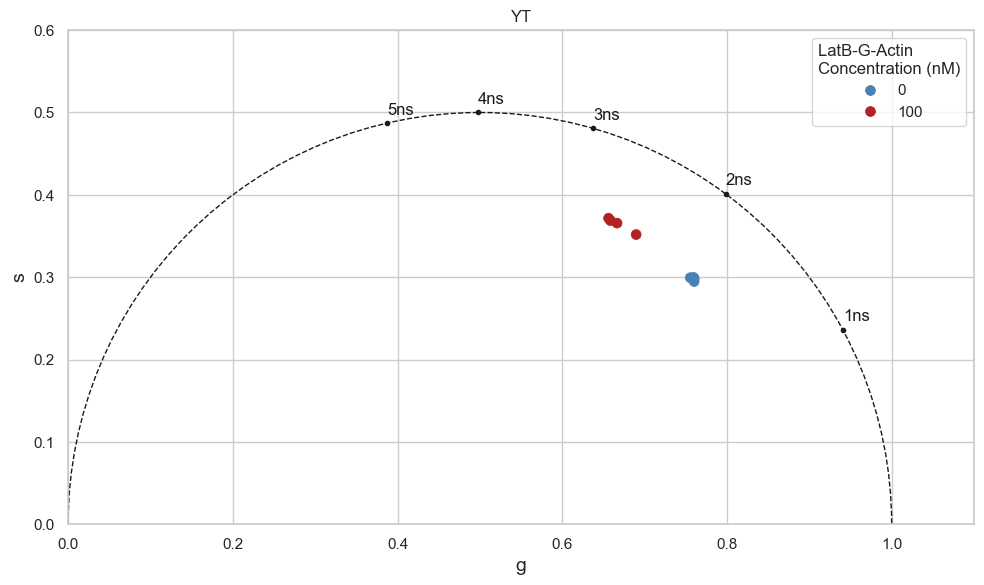

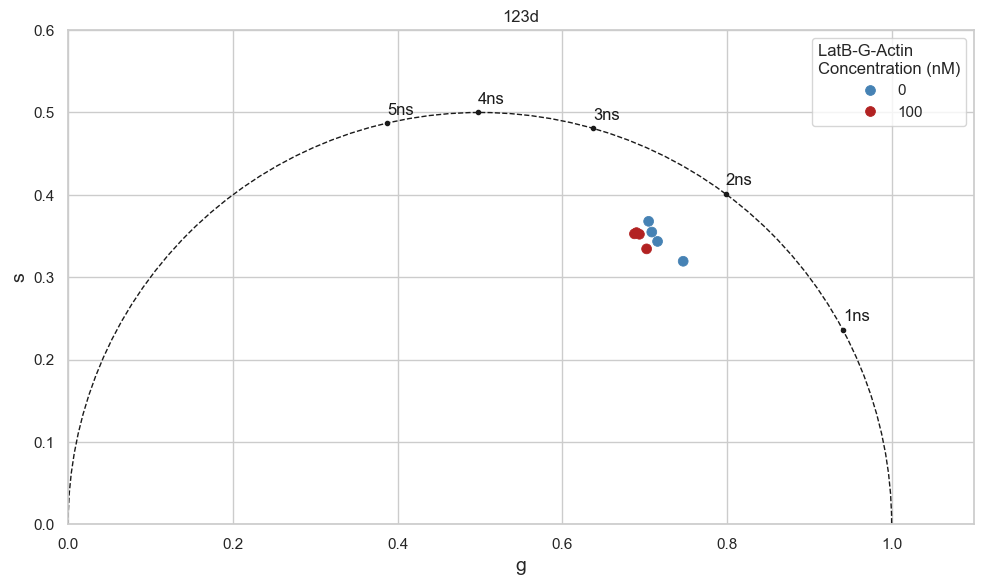

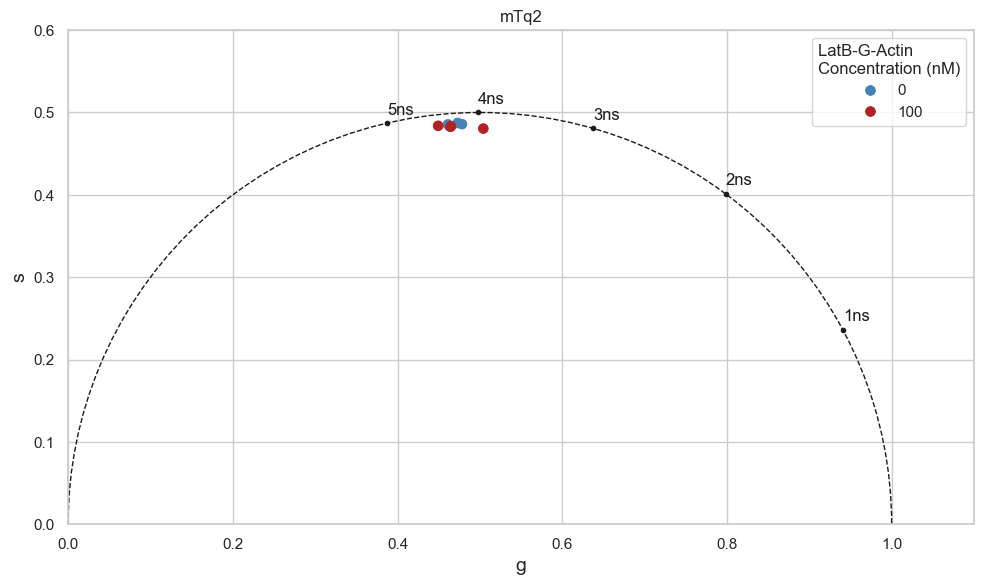

In [23]:
for construct in grouped_average["Construct"].unique():
    subset = grouped_average[grouped_average["Construct"]==construct]
        
    # Create a figure
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_aspect('equal')
    
    # plot
    pp = sns.scatterplot(
        x = "g_value",
        y = "s_value",
        hue = "LatB-G-Actin Concentration uM",
        data = subset,
        ax = ax,
        alpha = 1,
        edgecolor = None,
        s = 50,
        marker = 'o',
        palette = {"0":"steelblue", "100":"firebrick"},
        legend = True
    )

    # add unit circle
    ax = phasor.add_unit_circle (ax, omega)

    pp.legend_.set_title("LatB-G-Actin \nConcentration (nM)")    
       
    # Adjust layout
    plt.title(construct)
    plt.tight_layout()
    plt.show()

In [12]:
group_order = ['mTq2', 'TqGL', '123b', '123d', 'EEE', 'VD-T2', 'YT']

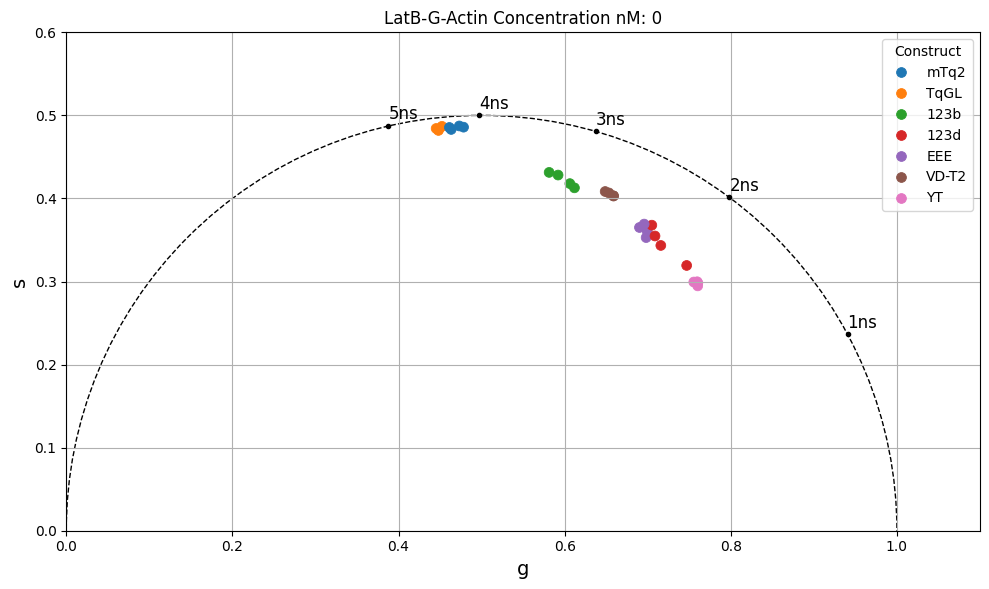

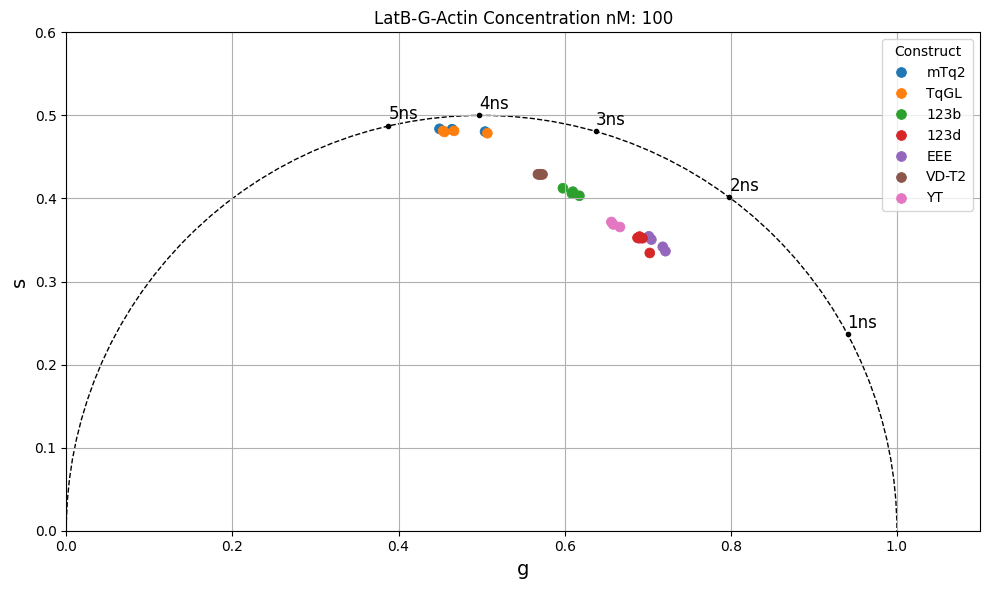

In [15]:
for treatment in grouped_average["LatB-G-Actin Concentration uM"].unique():
    subset = grouped_average[grouped_average["LatB-G-Actin Concentration uM"]==treatment]
        
    # Create a figure
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_aspect('equal')
    
    # plot
    pp = sns.scatterplot(
        x = "g_value",
        y = "s_value",
        hue = "Construct",
        hue_order=group_order,
        data = subset,
        ax = ax,
        alpha = 1,
        edgecolor = None,
        s = 50,
        marker = 'o',
        palette = 'tab10',
        legend = True
    )
    
    ax = phasor.add_unit_circle (ax, omega)
    
    # Set axis limits and labels
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 0.6])
    ax.set_xlabel('g', fontsize=14)
    ax.set_ylabel('s', fontsize=14)
    ax.set_facecolor('w')
    ax.grid(True)
    
    # Adjust layout
    plt.title(f"LatB-G-Actin Concentration nM: {treatment}")
    plt.tight_layout()
    plt.show()

### Plot fitted lifetime values from phase

In [16]:
group_order

['mTq2', 'TqGL', '123b', '123d', 'EEE', 'VD-T2', 'YT']

In [17]:
# Define the order explicitly
grouped_average["Construct"] = pd.Categorical(grouped_average["Construct"], categories=['mTq2', 'TqGL', '123b', '123d', 'EEE', 'VD-T2', 'YT'], ordered=True)

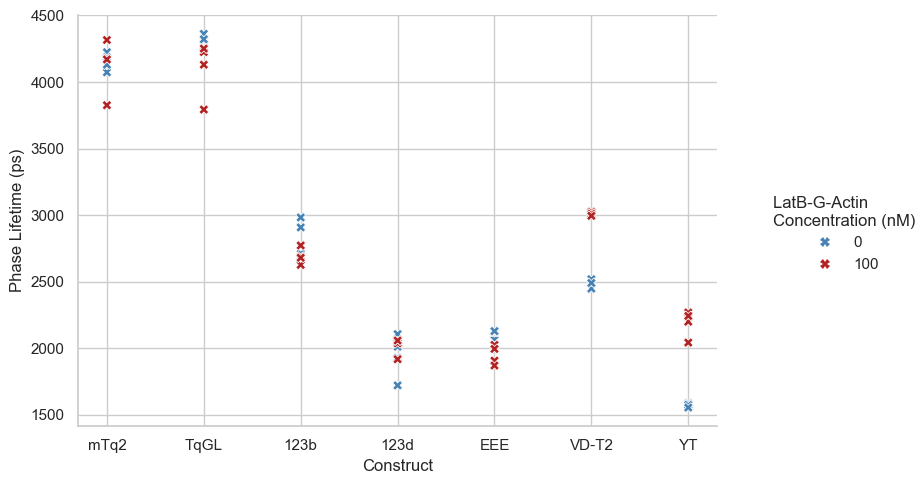

In [18]:
sns.set(style = 'whitegrid')

g = sns.relplot(
    data = grouped_average,
    x = 'Construct',
    y = 'phase_lifetime_ps',
    hue = 'LatB-G-Actin Concentration uM',
    kind = 'scatter',
    marker = 'X',
    s = 50,
    palette = {"0":"steelblue", "100":"firebrick"},
    facet_kws = {"sharex":True, "sharey":True}
)

g.set_axis_labels("Construct","Phase Lifetime (ps)")
g._legend.set_bbox_to_anchor((1.25, 0.5))
g._legend.set_title("LatB-G-Actin \nConcentration (nM)")

plt.tight_layout()

In [ ]:

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# Function to compute g and s for a given lifetime
def phasor_coords(tau, omega):
    lifetime = float(tau) * 1e-9
    g = 1 / (1 + (omega * lifetime) ** 2)
    s = (omega * lifetime) / (1 + (omega * lifetime) ** 2)
    return (g, s)

# Function to add unit circle to plot
def add_unit_circle (ax, lifetimes = [5, 4, 3, 2, 1]):
    # Plot the unit circle for reference
    circle = plt.Circle((0.5, 0), 0.5, color='k', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)
    
    # Add single lifetime values
    for tau in (lifetimes):
        g, s = phasor_coords(tau, omega)
        ax.plot(g, s, '.', color='k') 
        ax.text(g, s+0.025, f'{tau}ns', color='k', fontsize=12, ha='left', va='top', )

    return ax

def get_values_image_id (conn, image_id, keys = None, output = []):
    
    """
    Gets image object from OMERO.
    Converts image planes to nested lists.
    Reads metadata to aid with plotting.

    Parameters:
        conn: OMERO blitz gateway connection
        image_id (int): OMERO image ID
        keys (list): optional list of relevant metadata keys (strings) to add to the output array 
        output (list): nested lists for values at x,y coords.

    Returns:
        headings, output: phasor plot, intensity, modulation and phase lifetime images.
    """

    # get OMERO image object and read metadata
    img = conn.getObject("Image", image_id)
    image_name = img.getName()
    
    # read metadata map annotations (k-v pairs)
    metadata_dict = {}
    for ann in img.listAnnotations():
        map_ann = conn.getObject("MapAnnotation", ann.getId())
        for k, v in map_ann.getValue():
            metadata_dict[k] = v

    if type(keys) != list:
        keys = [keys]
        
    list_of_keys = ["Donor", "Acceptor"] + keys

    values = []
    for key in list_of_keys:
        value = metadata_dict[key]
        values.append(value)

    # get image planes
    zct_list = list((0, c, 0) for c in range(5))
    pixels = img.getPrimaryPixels()
    planes = pixels.getPlanes(zct_list)  # This is a generator, loading only when needed
    int_array, mod_lft_array, phase_lft_array, g_values_array, s_values_array = np.array([plane for plane in planes])  # Ensure correct shape

    headings = ["image_id"] + list_of_keys + ["intensity", "modulation_lifetime_ps", "phase_lifetime_ps", "g_value", "s_value"]

    # append values to output
    for x,y in np.argwhere(int_array):
        metadata_values = [image_id] + values
        output.append(metadata_values + [int_array[x,y], mod_lft_array[x,y], phase_lft_array[x,y], g_values_array[x,y], s_values_array[x,y]])

    return headings, output

In [ ]:


def scatterplot_phasor (conn, list_of_image_ids, keys = None, vmin=1000, vmax = 5000):
    
    """
    Function to generate phasor plot from FLIM data uploaded onto OMERO that already has g and s values calculated.
    Reads image metadata to get omega value and donor/acceptor info
    Plots g and s values with a hex-bin plot and draws a calibrated universal semi-circle.

    Parameters:
        conn: OMERO blitz gateway connection
        image_id (int): OMERO image ID
        keys (list): optional list of relevant metadata keys (strings) to add to the plot title 
        gridsize (int): size of hexbin
        vmin, vmax (int): min and max values for normalising lifetime images

    Returns:
        fig, gs: phasor plot, intensity, modulation and phase lifetime images.
    """

    if type(list_of_image_ids) != list:
        list_of_image_ids = [list_of_image_ids]

    # get phasor plotting variables from first image_id
    # get OMERO image object and read metadata
    img = conn.getObject("Image", list_of_image_ids[0])
    image_name = img.getName()
    channel_labels = img.getChannelLabels()
    pixel_size_um = img.getPixelSizeX()

    # read metadata annotations (k-v pairs)
    metadata_dict = {}
    for ann in img.listAnnotations():
        map_ann = conn.getObject("MapAnnotation", ann.getId())
        for k, v in map_ann.getValue():
            metadata_dict[k] = v
    
    omega = float(metadata_dict["omega"])

    output = []

    for image_id in list_of_image_ids:

        # get OMERO image object and read metadata
        img = conn.getObject("Image", image_id)
        image_name = img.getName()
        
        # read metadata annotations (k-v pairs)
        metadata_dict = {}
        for ann in img.listAnnotations():
            map_ann = conn.getObject("MapAnnotation", ann.getId())
            for k, v in map_ann.getValue():
                metadata_dict[k] = v
                
        donor = metadata_dict["Donor"]
        acceptor = metadata_dict["Acceptor"]
    
        # get image planes
        px = img.getPrimaryPixels()
        int_array = np.array(px.getPlane(0, 0, 0))
        #mod_lft_array = np.array(px.getPlane(0, 1, 0))
        #phase_lft_array = np.array(px.getPlane(0, 2, 0))
        g_values_array = np.array(px.getPlane(0, 3, 0))
        s_values_array = np.array(px.getPlane(0, 4, 0))

        # append values to output
        for x,y in np.argwhere(int_array):
            output.append([image_id, int_array[x,y], g_values_array[x,y], s_values_array[x,y]])

    # convert output values to pandas dataframe
    df = pd.DataFrame(output, columns = ["image_id", "intensity", "g_value", "s_value"])
    
    # Create a figure
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_aspect('equal')

    # plot
    pp = sns.scatterplot(
        x = "g_value",
        y = "s_value",
        hue = "image_id",
        data = df,
        ax = ax,
        alpha = 1,
        edgecolor = None,
        s = 1,
        marker = '.',
        palette = 'Set1',
        legend = True
    )

    # Plot the unit circle for reference
    circle = plt.Circle((0.5, 0), 0.5, color='k', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)
    
    # Lifetimes to plot on universal semi-circle (in ns)
    lifetimes = [5, 4, 3, 2, 1]
    
    # Add single lifetime values
    for tau in (lifetimes):
        g, s = phasor_coords(tau, omega)
        ax.plot(g, s, '.', color='k') 
        ax.text(g, s+0.025, f'{tau}ns', color='k', fontsize=12, ha='left', va='top', ) 

    # Set axis limits and labels
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 0.6])
    ax.set_xlabel('g', fontsize=18)
    ax.set_ylabel('s', fontsize=18)
    ax.set_facecolor('w')
    ax.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    return df

In [ ]:
df = scatterplot_phasor(conn, [346540, 346689, 346577, 346697])

## Utilise superpixels to reduce variance

In [ ]:
from skimage import segmentation

def scatterplot_superpixel_phasor (conn, list_of_image_ids, keys = None, hue_k = "image_id", n_segments = 200, vmin=1000, vmax = 5000):
    
    """
    Function to generate phasor plot from FLIM data uploaded onto OMERO that already has g and s values calculated.
    Reads image metadata to get omega value and donor/acceptor info
    Plots g and s values with a hex-bin plot and draws a calibrated universal semi-circle.

    Parameters:
        conn: OMERO blitz gateway connection
        image_id (int): OMERO image ID
        keys (list): optional list of relevant metadata keys (strings) to add to the plot title 
        gridsize (int): size of hexbin
        vmin, vmax (int): min and max values for normalising lifetime images

    Returns:
        fig, gs: phasor plot, intensity, modulation and phase lifetime images.
    """

    if type(list_of_image_ids) != list:
        list_of_image_ids = [list_of_image_ids]

    # get phasor plotting variables from first image_id
    # get OMERO image object and read metadata
    img = conn.getObject("Image", list_of_image_ids[0])
    image_name = img.getName()
    channel_labels = img.getChannelLabels()
    pixel_size_um = img.getPixelSizeX()

    # read metadata annotations (k-v pairs)
    metadata_dict = {}
    for ann in img.listAnnotations():
        map_ann = conn.getObject("MapAnnotation", ann.getId())
        for k, v in map_ann.getValue():
            metadata_dict[k] = v
    
    omega = float(metadata_dict["omega"])

    output = []

    for image_id in list_of_image_ids:

        # get OMERO image object and read metadata
        img = conn.getObject("Image", image_id)
        image_name = img.getName()
        
        # read metadata annotations (k-v pairs)
        metadata_dict = {}
        for ann in img.listAnnotations():
            map_ann = conn.getObject("MapAnnotation", ann.getId())
            for k, v in map_ann.getValue():
                metadata_dict[k] = v
                
        donor = metadata_dict["Donor"]
        acceptor = metadata_dict["Acceptor"]

        if hue_k == "image_id":
            hue_v = image_id
        else:
            hue_v = metadata_dict[hue_k]
    
        # get image planes
        px = img.getPrimaryPixels()
        int_array = np.array(px.getPlane(0, 0, 0))
        #mod_lft_array = np.array(px.getPlane(0, 1, 0))
        #phase_lft_array = np.array(px.getPlane(0, 2, 0))
        g_values_array = np.array(px.getPlane(0, 3, 0))
        s_values_array = np.array(px.getPlane(0, 4, 0))

        valid_image = np.nan_to_num(int_array, nan=np.nanmean(int_array)) # convert nans to mean of the plane
        slic = segmentation.slic (valid_image, n_segments=n_segments, channel_axis = None, start_label=1)

        for i in range(n_segments):  
            sup_px = i+1
            results = [image_id, sup_px, hue_v]
            # append values to output
            for plane in [int_array, g_values_array, s_values_array]:
                results.append(np.nanmean(plane[slic == sup_px]))
            output.append(results)            

    # convert output values to pandas dataframe
    df = pd.DataFrame(output, columns = ["id", "spx", hue_k, "intensity", "g_value", "s_value"])
    
    # Create a figure
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_aspect('equal')

    # plot
    pp = sns.scatterplot(
        x = "g_value",
        y = "s_value",
        hue = hue_k,
        data = df,
        ax = ax,
        alpha = 1,
        edgecolor = None,
        s = 20,
        marker = '.',
        palette = 'tab10',
        legend = True
    )

    # Plot the unit circle for reference
    circle = plt.Circle((0.5, 0), 0.5, color='k', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)
    
    # Lifetimes to plot on universal semi-circle (in ns)
    lifetimes = [5, 4, 3, 2, 1]
    
    # Add single lifetime values
    for tau in (lifetimes):
        g, s = phasor_coords(tau, omega)
        ax.plot(g, s, '.', color='k') 
        ax.text(g, s+0.025, f'{tau}ns', color='k', fontsize=12, ha='left', va='top', ) 

    # Set axis limits and labels
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 0.6])
    ax.set_xlabel('g', fontsize=18)
    ax.set_ylabel('s', fontsize=18)
    ax.set_facecolor('w')
    ax.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    return df

In [ ]:
df = scatterplot_superpixel_phasor(conn, [346540, 346689, 346577, 346697], n_segments = 100)
df

#### Once s and g have been calculated, a phasor plot is a scatterplot with a unit semi-circle to calibrate the single component lifetime values.
- get list of image IDs
- get omega value
- Convert plane information into a pandas data frame for plotting
- the unit semi-circle 

In [ ]:
def get_values_image_id (conn, image_id, keys = None, output = []):
    
    """
    Gets image object from OMERO.
    Converts image planes to nested lists.
    Reads metadata to aid with plotting.

    Parameters:
        conn: OMERO blitz gateway connection
        image_id (int): OMERO image ID
        keys (list): optional list of relevant metadata keys (strings) to add to the output array 
        output (list): nested lists for values at x,y coords.

    Returns:
        headings, output: phasor plot, intensity, modulation and phase lifetime images.
    """

    # get OMERO image object and read metadata
    img = conn.getObject("Image", image_id)
    image_name = img.getName()
    
    # read metadata map annotations (k-v pairs)
    metadata_dict = {}
    for ann in img.listAnnotations():
        map_ann = conn.getObject("MapAnnotation", ann.getId())
        for k, v in map_ann.getValue():
            metadata_dict[k] = v

    if type(keys) != list:
        keys = [keys]
        
    list_of_keys = ["Donor", "Acceptor", "Construct"] + keys

    values = []
    for key in list_of_keys:
        value = metadata_dict[key]
        values.append(value)

    # get image planes
    zct_list = list((0, c, 0) for c in range(5))
    pixels = img.getPrimaryPixels()
    planes = pixels.getPlanes(zct_list)  # This is a generator, loading only when needed
    int_array, mod_lft_array, phase_lft_array, g_values_array, s_values_array = np.array([plane for plane in planes])  # Ensure correct shape

    headings = ["image_id"] + list_of_keys + ["intensity", "modulation_lifetime_ps", "phase_lifetime_ps", "g_value", "s_value"]

    # append values to output
    for x,y in np.argwhere(int_array):
        metadata_values = [image_id] + values
        output.append(metadata_values + [int_array[x,y], mod_lft_array[x,y], phase_lft_array[x,y], g_values_array[x,y], s_values_array[x,y]])

    return headings, output

In [ ]:
def slic_to_dataframe (conn, list_of_image_ids, keys = None, n_segments = 200):
    
    """
    Function to generate phasor plot from FLIM data uploaded onto OMERO that already has g and s values calculated.
    Reads image metadata to get omega value and donor/acceptor info
    Plots g and s values with a hex-bin plot and draws a calibrated universal semi-circle.

    Parameters:
        conn: OMERO blitz gateway connection
        image_id (int): OMERO image ID
        keys (list): optional list of relevant metadata keys (strings) to add to the plot title 
        gridsize (int): size of hexbin
        vmin, vmax (int): min and max values for normalising lifetime images

    Returns:
        fig, gs: phasor plot, intensity, modulation and phase lifetime images.
    """

    if type(list_of_image_ids) != list:
        list_of_image_ids = [list_of_image_ids]

    output = []

    for image_id in list_of_image_ids:

        # get OMERO image object and read metadata
        img = conn.getObject("Image", image_id)
        image_name = img.getName()
        
        # read metadata annotations (k-v pairs)
        metadata_dict = {}
        for ann in img.listAnnotations():
            map_ann = conn.getObject("MapAnnotation", ann.getId())
            for k, v in map_ann.getValue():
                metadata_dict[k] = v
                
        #donor = metadata_dict["Donor"]
        #acceptor = metadata_dict["Acceptor"]
        list_of_keys = ["Donor", "Acceptor"] + keys

        values = []
        for key in list_of_keys:
            value = metadata_dict[key]
            values.append(value)
    
        # get image planes
        px = img.getPrimaryPixels()
        int_array = np.array(px.getPlane(0, 0, 0))
        #mod_lft_array = np.array(px.getPlane(0, 1, 0))
        #phase_lft_array = np.array(px.getPlane(0, 2, 0))
        g_values_array = np.array(px.getPlane(0, 3, 0))
        s_values_array = np.array(px.getPlane(0, 4, 0))

        valid_image = np.nan_to_num(int_array, nan=np.nanmean(int_array)) # convert nans to mean of the plane
        slic = segmentation.slic (valid_image, n_segments=n_segments, channel_axis = None, start_label=1)

        for i in range(n_segments):  
            sup_px = i+1
            results = [image_id, sup_px] + values
            # append values to output
            for plane in [int_array, g_values_array, s_values_array]:
                results.append(np.nanmean(plane[slic == sup_px]))
            output.append(results)    

    headings = ["id", "spx"] + list_of_keys + ["intensity", "g_value", "s_value"]

    # convert output values to pandas dataframe
    df = pd.DataFrame(output, columns = headings)

    return df

In [ ]:
headings, output = get_values_image_id (conn, image_id, keys = "omega")

In [ ]:
headings, output = get_values_image_id (conn, image_id, keys = "omega", output = output)

In [ ]:
len(headings)

In [ ]:
headings

In [ ]:
output[0]

In [ ]:
project_id = 4853
list_of_ids = omero.find_image_ids_in_project_kv_dict (conn, project_id, {"image_processing": "background subtraction"})

In [ ]:
list_of_ids[0]

In [ ]:
df = slic_to_dataframe (conn, list_of_ids, keys = ["Construct", "Sample ID","LatB-G-Actin Concentration uM"], n_segments = 200)

In [ ]:
df

In [ ]:
image_id = 346540
img = conn.getObject("Image", image_id)
# get image planes
zct_list = list((0, c, 0) for c in range(5))
pixels = img.getPrimaryPixels()
planes = pixels.getPlanes(zct_list)  # This is a generator, loading only when needed
int_array, mod_lft_array, phase_lft_array, g_values_array, s_values_array = np.array([plane for plane in planes])  # Ensure correct shape


In [ ]:
int_array

In [ ]:
img = conn.getObject("Image", list_of_ids[0])
# read metadata annotations (k-v pairs)
metadata_dict = {}
for ann in img.listAnnotations():
    map_ann = conn.getObject("MapAnnotation", ann.getId())
    for k, v in map_ann.getValue():
        metadata_dict[k] = v

omega = float(metadata_dict["omega"])

In [ ]:
# Function to compute g and s for a given lifetime
def phasor_coords(tau, omega):
    lifetime = float(tau) * 1e-9
    g = 1 / (1 + (omega * lifetime) ** 2)
    s = (omega * lifetime) / (1 + (omega * lifetime) ** 2)
    return (g, s)

# Function to add unit circle to plot
def add_unit_circle (ax, lifetimes = [5, 4, 3, 2, 1]):
    # Plot the unit circle for reference
    circle = plt.Circle((0.5, 0), 0.5, color='k', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)
    
    # Add single lifetime values
    for tau in (lifetimes):
        g, s = phasor_coords(tau, omega)
        ax.plot(g, s, '.', color='k') 
        ax.text(g, s+0.025, f'{tau}ns', color='k', fontsize=12, ha='left', va='top', )

    return ax

In [ ]:
# Create a figure
fig, ax = plt.subplots(figsize = (10, 6))
ax.set_aspect('equal')

# plot
pp = sns.scatterplot(
    x = "g_value",
    y = "s_value",
    hue = "LatB-G-Actin Concentration uM",
    data = df,
    ax = ax,
    alpha = 1,
    edgecolor = None,
    s = 20,
    marker = '.',
    palette = {"0":"steelblue", "100":"firebrick"},
    legend = True
)

ax = add_unit_circle (ax)

# Set axis limits and labels
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 0.6])
ax.set_xlabel('g', fontsize=14)
ax.set_ylabel('s', fontsize=14)
ax.set_facecolor('w')
ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
for sample_id in df["Sample ID"].unique():
    subset = df[df["Sample ID"]==sample_id]
    
    donor = subset["Donor"].unique()[0]
    acceptor = subset["Acceptor"].unique()[0]

    # Create a figure
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_aspect('equal')

    # plot
    pp = sns.scatterplot(
        x = "g_value",
        y = "s_value",
        hue = "LatB-G-Actin Concentration uM",
        data = subset,
        ax = ax,
        alpha = 1,
        edgecolor = None,
        s = 20,
        marker = '.',
        palette = {"0":"steelblue", "100":"firebrick"},
        legend = True
    )

    # Plot the unit circle for reference
    circle = plt.Circle((0.5, 0), 0.5, color='k', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)
    
    # Lifetimes to plot on universal semi-circle (in ns)
    lifetimes = [5, 4, 3, 2, 1]
    
    # Add single lifetime values
    for tau in (lifetimes):
        g, s = phasor_coords(tau, omega)
        ax.plot(g, s, '.', color='k') 
        ax.text(g, s+0.025, f'{tau}ns', color='k', fontsize=12, ha='left', va='top', ) 

    # Set axis limits and labels
    ax.set_xlim([0, 1.1])
    ax.set_ylim([0, 0.6])
    ax.set_xlabel('g', fontsize=18)
    ax.set_ylabel('s', fontsize=18)
    ax.set_facecolor('w')
    ax.grid(True)
    
    # Adjust layout
    plt.title(f"{sample_id}\n Donor:{donor}\n Acceptor:{acceptor}")
    plt.tight_layout()
    plt.show()
    

In [ ]:
list((0, c, 0) for c in range(5))

In [ ]:
df = scatterplot_superpixel_phasor(conn, list_of_ids, hue_k = "Sample ID", n_segments = 100)
df